In [1]:
# pip install pmdarima

import pandas as pd
import numpy as np
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

# increase columns and rows for display to have a better view of the dataframe
pd.set_option("display.max_columns", 100)
pd.set_option("display.min_rows", 100)
%matplotlib inline

In [2]:
# Read dataset 
df = pd.read_csv('residential_price_index_by_country_monthly.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 215 entries, 0 to 214
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   month              215 non-null    object 
 1   IE                 215 non-null    float64
 2   UK                 215 non-null    float64
 3   IE_prev            215 non-null    float64
 4   UK_prev            215 non-null    float64
 5   IE_diff_prev       215 non-null    float64
 6   UK_diff_prev       215 non-null    float64
 7   IE_diff_prev_sign  215 non-null    object 
 8   UK_diff_prev_sign  215 non-null    object 
dtypes: float64(6), object(3)
memory usage: 15.2+ KB


In [3]:
df2 = df[['month','IE']]
df2['month'] = pd.to_datetime(df2['month'], format='%Y-%m')
df2.set_index('month', inplace=True)
df2

,IE
month,
2005-02-01,125.9
2005-03-01,126.6
2005-04-01,127.5
2005-05-01,128.4
2005-06-01,129.5
2005-07-01,131.6
2005-08-01,133.8
2005-09-01,135.2
2005-10-01,138.1


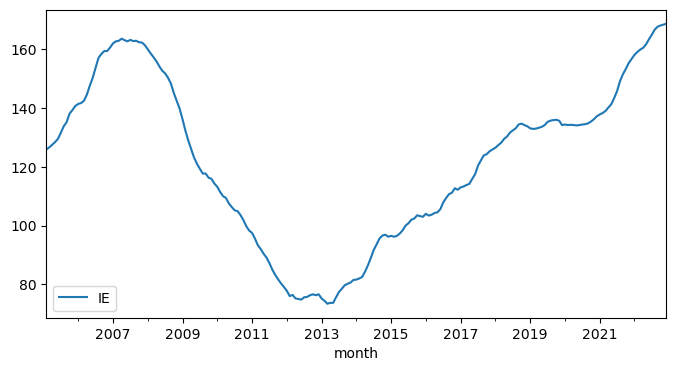

In [4]:
df2.plot(figsize=(8,4),legend=True);

In [5]:
# Apply auto_arima function to get best combination of orders for the model and dataset provided
auto_arima(df2['IE'], trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,2,2)(0,0,0)[0]             : AIC=455.760, Time=0.33 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=477.724, Time=0.04 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=451.620, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=457.175, Time=0.06 sec
 ARIMA(2,2,0)(0,0,0)[0]             : AIC=451.858, Time=0.07 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=451.900, Time=0.11 sec
 ARIMA(2,2,1)(0,0,0)[0]             : AIC=453.826, Time=0.10 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=453.616, Time=0.07 sec

Best model:  ARIMA(1,2,0)(0,0,0)[0]          
Total fit time: 0.872 seconds


ARIMA(order=(1, 2, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [6]:
# Split the model into training and testing but without taking to much from the tail 
# due to raising trend at the end, it would not be captured in the prediction
train=df2.iloc[:-12]
test=df2.iloc[-12:]
print(train.shape,test.shape)

(203, 1) (12, 1)


In [7]:
# Train the model with orders provided by auto_arima function
model=ARIMA(train['IE'],order=(1,2,0))
model=model.fit()
#model.summary()

In [10]:
# Prediction start and end index
start=len(train) #star to make prediction from the end of training set
end=len(train)+len(test)-1

# Make prediction
pred=model.predict(start=start,end=end,typ='levels').rename('ARIMA Predictions')
print(pred)

2022-01-01    158.317642
2022-02-01    159.856337
2022-03-01    161.423669
2022-04-01    162.980613
2022-05-01    164.541325
2022-06-01    166.100671
2022-07-01    167.660512
2022-08-01    169.220173
2022-09-01    170.779900
2022-10-01    172.339603
2022-11-01    173.899315
2022-12-01    175.459023
Freq: MS, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:xlabel='month'>

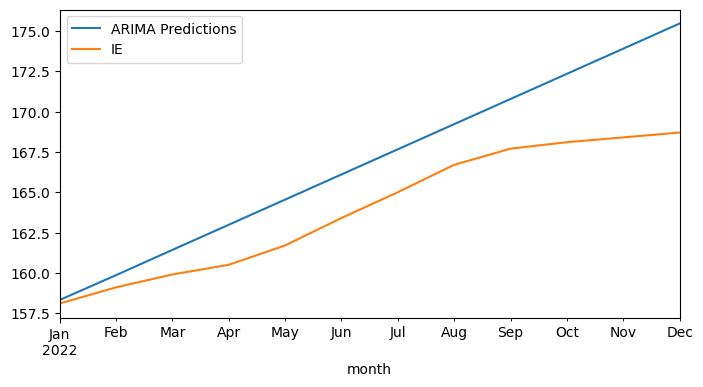

In [11]:
pred.plot(figsize=(8,4),legend=True)
test['IE'].plot(legend=True)

In [12]:
mean = test['IE'].mean()
rmse = sqrt(mean_squared_error(pred,test['IE']))

print('mean = ', mean)
print('mean sqr err = ', rmse)

mean =  163.94166666666666
mean sqr err =  3.4312004820036477


The model is good, therefore apply to entire dataset to make predictions into the future

In [13]:
# Train the model with orders provided by auto_arima function and entire dataset
model2 = ARIMA(df2['IE'],order=(1,2,0))
model2 = model2.fit()

In [14]:
# Make predictions into the future, 24 months from final record
pred = model2.predict(start=len(df2), end=len(df2)+12, typ='levels').rename('ARIMA Predictions')
print(pred)

2023-01-01    169.0
2023-02-01    169.3
2023-03-01    169.6
2023-04-01    169.9
2023-05-01    170.2
2023-06-01    170.5
2023-07-01    170.8
2023-08-01    171.1
2023-09-01    171.4
2023-10-01    171.7
2023-11-01    172.0
2023-12-01    172.3
2024-01-01    172.6
Freq: MS, Name: ARIMA Predictions, dtype: float64


<AxesSubplot:xlabel='month'>

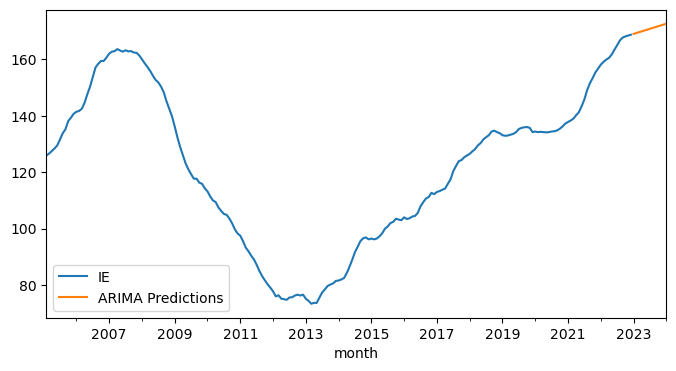

In [15]:
# Plot extended dataset with prediction
df2['IE'].plot(figsize=(8,4),legend=True)
pred.plot(legend=True)

In [16]:
# Import Logistic Regression Classifier and Random Forest Classifier 
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

#Import scikit-learn metrics module for accuracy calculation
from sklearn import metrics

In [17]:
df3 = df[['month', 'IE','IE_prev','IE_diff_prev']]

df3['month'] = pd.to_datetime(df3['month'], format='%Y-%m')
df3.set_index('month', inplace=True)

df3

,IE,IE_prev,IE_diff_prev
month,,,
2005-02-01,125.9,124.9,1.0
2005-03-01,126.6,125.9,0.7
2005-04-01,127.5,126.6,0.9
2005-05-01,128.4,127.5,0.9
2005-06-01,129.5,128.4,1.1
2005-07-01,131.6,129.5,2.1
2005-08-01,133.8,131.6,2.2
2005-09-01,135.2,133.8,1.4
2005-10-01,138.1,135.2,2.9


In [18]:
x1 = df3['IE_prev']
x2 = df3['IE_diff_prev']
y = df3['IE']

x1,x2,y = np.array(x1), np.array(x2), np.array(y)
x1,x2,y = x1.reshape(-1,1), x2.reshape(-1,1), y.reshape(-1,1)
X = np.concatenate((x1,x2), axis=1)

In [19]:
X.shape, y.shape

((215, 2), (215, 1))

In [20]:
X_train, X_test, y_train, y_test = X[:-20], X[-20:], y[:-20], y[-20:]

In [21]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((195, 2), (20, 2), (195, 1), (20, 1))

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)

rfr = RandomForestRegressor()
rfr.fit(X_train, y_train)

RandomForestRegressor()

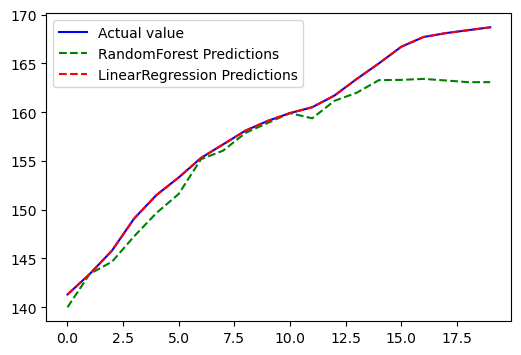

In [30]:
rfr_pred = rfr.predict(X_test)
lr_pred = lr.predict(X_test)

plt.rcParams['figure.figsize'] = (6,4)
plt.plot(y_test, 'b-', label='Actual value')
plt.plot(rfr_pred, 'g--', label='RandomForest Predictions')
plt.plot(lr_pred, 'r--', label='LinearRegression Predictions')
plt.legend(loc='upper left')
plt.show()

In [31]:
# test set mean
mean = y_test.mean()
print(f'Test set mean: {mean}')

# RandomForest Root Mean Square Error
rmse_rf = sqrt(metrics.mean_squared_error(rfr_pred,y_test))
print(f'RandomForest Root Mean Square Error: {rmse_rf}')

# LinearRegression Root Mean Square Error
rmse_lr = sqrt(metrics.mean_squared_error(lr_pred,y_test))
print(f'LinearRegression Root Mean Square Error: {rmse_lr}')

Test set mean: 158.185
RandomForest Root Mean Square Error: 2.580824848764352
LinearRegression Root Mean Square Error: 8.806144583576081e-14


In [24]:
stop

NameError: name 'stop' is not defined

In [30]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

In [31]:
print("Training set score: {:.2f}".format(lr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(lr.score(X_test, y_test)))

# Cross validation
cv_mean = round(cross_val_score(lr, X, y, cv = 20).mean(),2)
cv_std = round(cross_val_score(lr, X, y, cv = 20).std(),2)
cv_scores = np.around(cross_val_score(lr, X, y, cv = 20),2).tolist()

print(f'Cross validation accuracy mean: {cv_mean} +/- {cv_std}')
print(f'Cross validation accuracy results: {cv_scores}')

Training set score: 1.00
Test set score: 1.00
Cross validation accuracy mean: 1.0 +/- 0.0
Cross validation accuracy results: [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


In [32]:
print("Training set score: {:.2f}".format(rfr.score(X_train, y_train)))
print("Test set score: {:.2f}".format(rfr.score(X_test, y_test)))

# Cross validation
cv_mean = round(cross_val_score(rfr, X, y, cv = 20).mean(),2)
cv_std = round(cross_val_score(rfr, X, y, cv = 20).std(),2)
cv_scores = np.around(cross_val_score(rfr, X, y, cv = 20),2).tolist()

print(f'Cross validation accuracy mean: {cv_mean} +/- {cv_std}')
print(f'Cross validation accuracy results: {cv_scores}')

Training set score: 1.00
Test set score: 0.90
Cross validation accuracy mean: 0.62 +/- 0.51
Cross validation accuracy results: [0.95, 0.95, -1.53, 0.57, 0.82, 0.68, 0.78, 0.65, 0.58, 0.62, 0.55, 0.43, 0.77, 0.82, 0.97, 0.42, 0.56, 0.87, 0.96, -0.16]


In [ ]:
stop

In [33]:
# Initialise RandomForestClassifier
rfr2 = RandomForestRegressor()

# parameter dictionary for GridSearchCV
param_grid = {
    'n_estimators': [100,300,700],
    'max_depth': [None,10,15,20]
}

# Modelling with GridSearchCV result
rfr2_gr = GridSearchCV(rfr2, param_grid, cv=10)
rfr2_gr.fit(X_train, y_train)

print(rfr2_gr.best_estimator_)

# result = RandomForestRegressor(max_depth=10, n_estimators=700)

RandomForestRegressor(max_depth=10, n_estimators=700)


In [35]:
cv_scores = np.around(cross_val_score(rfr2_gr, X, y, cv = 20),2).tolist()
cv_mean = round(cv_scores.mean(),2)
cv_std = round(cv_scores.std(),2)

print(f'Cross validation accuracy mean: {cv_mean} +/- {cv_std}')
print(f'Cross validation accuracy results: {cv_scores}')

KeyboardInterrupt: 

In [34]:
# Make predictions on the testing set
y_pred = rfr2_gr.predict(X_test)

print("Training set score: {:.2f}".format(rfr2_gr.score(X_train, y_train))) # --> 1.00
print("Test set score: {:.2f}".format(rfr2_gr.score(X_test, y_test))) # --> 0.90

# Cross validation
cv_mean = round(cross_val_score(rfr2_gr, X, y, cv = 20).mean(),2)
cv_std = round(cross_val_score(rfr2_gr, X, y, cv = 20).std(),2)
cv_scores = np.around(cross_val_score(rfr2_gr, X, y, cv = 20),2).tolist()

print(f'Cross validation accuracy mean: {cv_mean} +/- {cv_std}')
print(f'Cross validation accuracy results: {cv_scores}')

Training set score: 1.00
Test set score: 0.90


KeyboardInterrupt: 

In [ ]:
stop